# Exercise 1
Linear models are an important class in data analysis problems. Your aim for this exercise is using such an approach modeling of !Kung people heights (applying Stan).

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from cmdstanpy import set_cmdstan_path, cmdstan_path
set_cmdstan_path('/home/jaqb/Documents/cmdstan-2.26.1')
cmdstan_path()

'/home/jaqb/Documents/cmdstan-2.26.1'

In [100]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults for now
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Using Stan create the linear model for presented data and interpret the results.

Centering weight:

In [101]:
d['c_weight']=d.weight-d.weight.mean()
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


Linear model for predicting height using weight as a predictor:
$$\textrm{height}_i\sim\textrm{Normal}(\mu_i, \sigma)$$
$$\mu_i=\alpha+\beta*\textrm{weight}_i$$
$$\alpha\sim\textrm{Normal}(178, 20)$$
$$\beta\sim\textrm{Lognormal}(0,1)$$
$$\sigma\sim\textrm{Exponential}(0,067)$$

$\alpha$ has a normal prior with mean=178, because we know it is the average height for many populations, and with centered weight it is expected height for average weight. $\beta$ and $\sigma$ have lognormal and exponential priors respectively, to limit their values to positive. $\sigma$ cannot be negative by itself and positive $\beta$ makes height bigger when weight is bigger. 

#### Prior predictive checks

Stan code to generate data:

In [103]:
with open('prior_predictive.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta = lognormal_rng(0,1);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta+alpha,sigma);
  }

}




In [104]:
model_prior_checks = CmdStanModel(stan_file='prior_predictive.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/prior_predictive
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/prior_predictive


In [105]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim_prior_checks=model_prior_checks.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [106]:
alpha_prior_checks=sim_prior_checks.stan_variable('alpha')
beta_prior_checks=sim_prior_checks.stan_variable('beta')

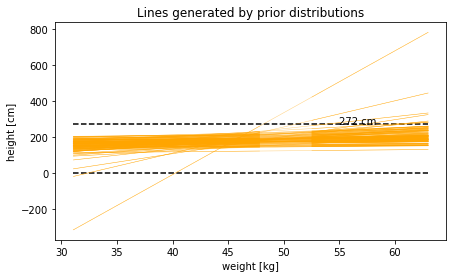

In [107]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,272],xmin=d.weight.min(),xmax=d.weight.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(d.weight,alpha_prior_checks[i]+beta_prior_checks[i]*d.c_weight,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.annotate(text='272 cm', xy=(55,272))
axes.set_title(r'Lines generated by prior distributions')
plt.show()



Most of the lines generated by taking values from priors are limited to realistic values (height between 0 and 272 cm - the height of the tallest man). Very strong relationship is also sometimes possible.

#### Posterior inference

Stan code:

In [10]:
with open('model_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = weight*beta+alpha;
}

model {
  alpha ~ normal(178,20);
  beta ~ lognormal(0,1);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}


In [11]:
model_fit=CmdStanModel(stan_file='model_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/model_fit


Sampling from the model:

In [12]:
data_fit=dict(N=len(d),
              weight=d.c_weight.values,
              heights=d.height.values)
fit=model_fit.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


Showing statistics and histograms of parameters posterior distributions:

In [13]:
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
sigma_fit=fit.stan_variable('sigma')
height_pred=fit.stan_variable('height')

az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,154.6,0.28,154.08,155.11
beta,0.9,0.04,0.83,0.98
sigma,5.1,0.20,4.70,5.45


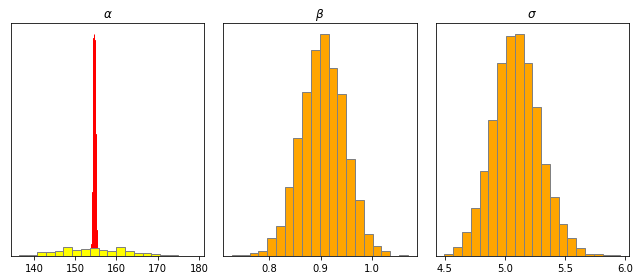

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(9, 4))
ax = axes[0]
ax.hist(alpha_fit,bins=20,color='orange',edgecolor='red',density=True)
ax.hist(d.height,bins=20,color='yellow',edgecolor='gray',density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1]
ax2.hist(beta_fit,bins=20,color='orange',edgecolor='gray',density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
ax3 = axes[2]
ax3.hist(sigma_fit,bins=20,color='orange',edgecolor='gray',density=True)
ax3.set_title(r'$\sigma$')
ax3.set_yticks(())
fig.tight_layout()
plt.show()

Standard deviation for $\alpha$ is small compared to the distribution of all heights, so the model is sure that its value lies around 155 cm. Posterior values for $\beta$ suggest that increasing weight 1 kg produces growth of height of 0,8-1 cm.  

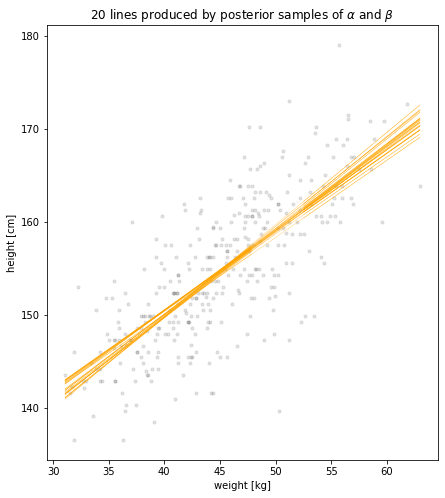

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 20
for i in range(n):
    ax0.plot(d.weight,
              alpha_fit[i]+beta_fit[i]*d.c_weight,
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.scatter(d.weight,d.height,color='black',alpha=0.1,s=10)
ax0.set_ylabel('height [cm]')
ax0.set_title(r'{} lines produced by posterior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('weight [kg]')

plt.show()

#### Prediction for selected weight

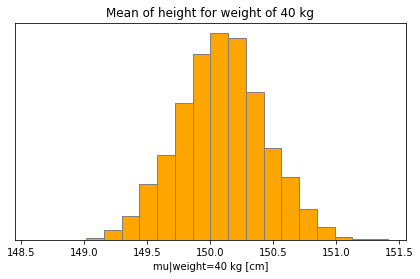

In [17]:
mean_weight40 = alpha_fit+beta_fit*(40-d.weight.mean())

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mean_weight40,bins=20,color='orange',edgecolor='gray',density=True)
ax.set_title('Mean of height for weight of 40 kg')
ax.set_yticks(())
ax.set_xlabel('mu|weight=40 kg [cm]')
plt.show()

In [18]:
az.summary(mean_weight40,round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
x,150.09,0.35,149.45,150.76


The range of heights mean for weight being 40 kg is quite narrow, having 3% HDI equals 149,41 and 97% HDI 150,73. 

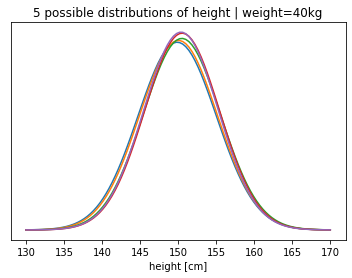

In [28]:
x = np.linspace(130, 170, 100)
n = 5
for i in range(n):
    plt.plot(x, stats.norm.pdf(x, mean_weight40[i], sigma_fit[i]))
plt.title('{} possible distributions of height | weight=40kg'.format(n))
plt.xlabel('height [cm]')
plt.yticks(())
plt.show()

# Exercise 2
Extend model of !Kung people height for the full dataset (including children) and discuss the results.

In [108]:
d= pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)

#### Standarization of variables

In [109]:
d['c_weight']=d.weight-d.weight.mean()
d['s_weight']=d['c_weight']/d['weight'].std()
d.head()

,height,weight,age,male,c_weight,s_weight
0,151.765,47.825606,63.0,1,12.214989,0.829869
1,139.700,36.485807,63.0,0,0.875189,0.059459
2,136.525,31.864838,65.0,0,-3.745780,-0.254483
3,156.845,53.041914,41.0,1,17.431297,1.184257
4,145.415,41.276872,51.0,0,5.666254,0.384957


Using previous model:

In [35]:
data_fit=dict(N=len(d),
              weight=d.c_weight.values,
              heights=d.height.values)

fit=model_fit.sample(data=data_fit)

alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
height_pred=fit.stan_variable('height')

az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


,mean,sd,hdi_3%,hdi_97%
alpha,138.28,0.41,137.55,139.09
beta,1.76,0.03,1.71,1.82
sigma,9.39,0.29,8.85,9.95


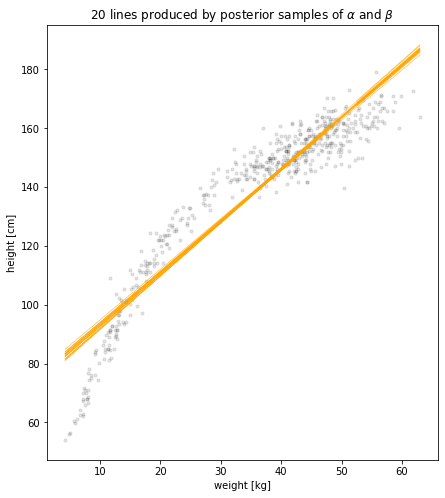

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes
n = 20
for i in range(n):
    ax0.plot(d.weight,
              alpha_fit[i]+beta_fit[i]*d.c_weight,
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.scatter(d.weight,d.height,color='black',alpha=0.1,s=10)
ax0.set_ylabel('height [cm]')
ax0.set_title(r'{} lines produced by posterior samples of $\alpha$ and $\beta$'.format(n))
ax0.set_xlabel('weight [kg]')

plt.show()

Including children in a dataset changes general shape of relationship between weight and height. The value of $\sigma$ is bigger than before, which suggests that model is less sure of the value of height given specific weight. It seems that better results could be obtained by fitting quadratic function:
$$\textrm{height}_i\sim\textrm{Normal}(\mu_i, \sigma)$$
$$\mu_i=\alpha+\beta_1*\textrm{weight}_i+(-\beta_2)*\textrm{weight}_i^2$$
$$\alpha\sim\textrm{Normal}(150, 20)$$
$$\beta_1\sim\textrm{Lognormal}(0,1)$$
$$\beta_2\sim\textrm{Lognormal}(0,1)$$
$$\sigma\sim\textrm{Exponential}(0,067)$$

Priors for $\beta_1$ $\sigma$ are the same as previously. Since children are included, prior for $\alpha$ was decreased to 150. Values from prior for $\beta_2$ are inserted to the model as negative ones, because the rate of change for smaller weights is bigger than for bigger ones (we expect concave quadratic function). 

#### Prior predictive checks

In [115]:
with open('prior_predictive_quadratic.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(150, 20);
  real beta1 = lognormal_rng(0,1);
  real beta2 = lognormal_rng(0,1);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta1+weight[i]^2*(-beta2)+alpha,sigma);
  }

}


In [116]:
model_prior_quadratic_checks = CmdStanModel(stan_file='prior_predictive_quadratic.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/prior_predictive_quadratic
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/prior_predictive_quadratic


In [117]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim_prior_quadratic_checks=model_prior_quadratic_checks.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [118]:
alpha_prior_quadratic_checks=sim_prior_quadratic_checks.stan_variable('alpha')
beta1_prior_quadratic_checks=sim_prior_quadratic_checks.stan_variable('beta1')
beta2_prior_quadratic_checks=sim_prior_quadratic_checks.stan_variable('beta2')

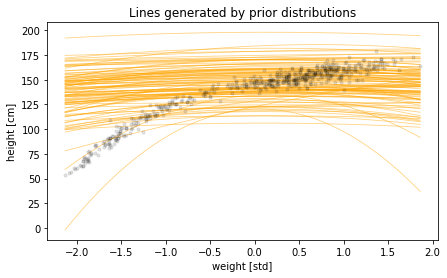

In [159]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
x = np.sort(d.s_weight)
for i in range(100):
    axes.plot(x,alpha_prior_quadratic_checks[i]+beta1_prior_quadratic_checks[i]*x-beta2_prior_quadratic_checks[i]*x**2,color='orange',alpha=0.5,linewidth=0.8)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10, zorder=100)
axes.set_xlabel('weight [std]')
axes.set_ylabel('height [cm]')
axes.set_title(r'Lines generated by prior distributions')
plt.show()

#### Posterior inference

In [122]:
with open('quadratic_model.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta1;
  real beta2;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = weight[i]*beta1+weight[i]^2*(-beta2)+alpha;
  }
}

model {
  alpha ~ normal(150, 20);
  beta1 ~ lognormal(0,1);
  beta2 ~ lognormal(0,1);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}




In [123]:
quadratic_model_fit=CmdStanModel(stan_file='quadratic_model.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/quadratic_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab5/quadratic_model


In [124]:
data_fit=dict(N=len(d),
              weight=d.s_weight.values,
              heights=d.height.values)

fit=quadratic_model_fit.sample(data=data_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [164]:
alpha = fit.stan_variable('alpha')
beta1 = fit.stan_variable('beta1')
beta2 = fit.stan_variable('beta2')
sigma = fit.stan_variable('sigma')

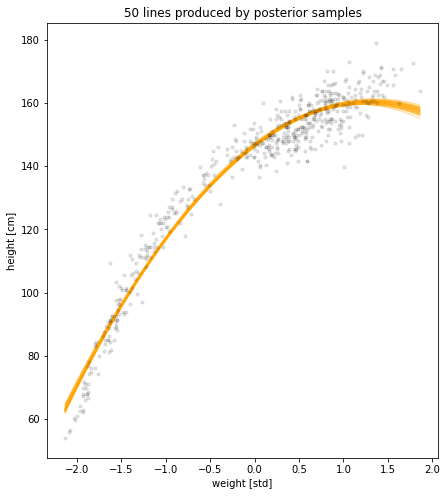

In [165]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8))
ax0=axes
n = 50
x = np.sort(d.s_weight)
for i in range(n):
    ax0.plot(x,
              alpha[i]+beta1[i]*x-beta2[i]*x**2,
              color='orange',
              alpha=0.5,linewidth=0.5)
ax0.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10, zorder=100)
ax0.set_ylabel('height [cm]')
ax0.set_title(r'{} lines produced by posterior samples'.format(n))
ax0.set_xlabel('weight [std]')

plt.show()

In [160]:
az.summary(fit,var_names=['alpha','beta1','beta2','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,146.62,0.37,145.96,147.35
beta1,21.43,0.29,20.87,21.98
beta2,8.38,0.28,7.89,8.95
sigma,5.78,0.18,5.46,6.10


Fitting a quadratic function instead of a linear one let us create better model for the whole dataset. The mean for $\sigma$ is again less than 6, which suggests that model is more confident about the value of height given specific weight.  